In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import json

from src.utils import SimpleLogger
import src.utils as utils

# from src.preprocess import Preprocessor

config = utils.load_config()

logger = SimpleLogger(name="Logger-main", log_path="logs/logger_main_private7.5.log")

# Add memory_profiler for memory usage
# try:
#     from memory_profiler import memory_usage
# except ImportError:
#     memory_usage = None
#     logger.warning("Warning: memory_profiler is not installed. Install it with 'pip install memory_profiler' for memory usage tracking.")

VAR_MAP = {
    "swvl1": "swvl1",
    "ro": "ro",
    "e": "e",
    "tp": "tp"
}

CHANNELS = {
    "swvl1": 0,
    "ro": 1,
    "e": 2,
    "tp": 3
}

from src.visualize import ArrayInfoDisplayer

array_info_displayer = ArrayInfoDisplayer(logger=logger)

In [2]:
# shows the config we are using
logger.info("Using config:\n" + json.dumps(config, indent=2, ensure_ascii=False))

[2025-07-21 18:44:49.625] [INFO] Using config:
{
  "model": "empty_model",
  "per_year_outputs_path": "/mnt/c/Users/jebediahc/OneDrive/鱼丸车仔/TUM-before-arrival/Project Earth Observation Data Analysis/Project-files-Soil-Moisture/per_year_outputs/",
  "date": "2020-01-15",
  "raw_path": "data/raw",
  "processed_path": "data/processed",
  "demo_path": "data/demo",
  "demo_nc_path": "data/demo/2020-1.nc",
  "demo_datetime": "2020-01-01T12:00:00",
  "months": [
    "2020-1",
    "2020-2",
    "2020-3",
    "2020-4"
  ],
  "run_name": "test-2",
  "raw_folder": "data/raw",
  "intermediate_folder": "data/processed",
  "use_channels": [
    "swvl1",
    "ro",
    "e",
    "tp"
  ],
  "input_days": 20,
  "predict_days": 10,
  "batch_size": 4,
  "epochs": 100
}


In [3]:
# --- STEP 1: LAT/LON and NetCDF info---
# Show NetCDF file format info
sample_nc = xr.open_dataset(os.path.join(config["raw_folder"], f"{config['months'][0]}.nc"))

lat = sample_nc['latitude'].values
lon = sample_nc['longitude'].values

print(sample_nc)
print("\nNetCDF file info:")
sample_nc.info()

# --- 陆地掩膜生成与应用（海洋去除）---
# # 读取第一个月的 NetCDF 文件，假设掩膜变量名为 'lsm'，如无请修改为实际变量名
# if 'lsm' in sample_nc.variables:
#     land_mask = sample_nc['lsm'].values  # shape: (lat, lon)，1为陆地，0为海洋
#     # 若掩膜有时间维度，取第一个时间点
#     if land_mask.ndim == 3:
#         land_mask = land_mask[0]
# else:
#     # 若无掩膜变量，可用经纬度范围简单生成（仅示例，建议用真实掩膜）
#     lat = sample_nc['latitude'].values
#     lon = sample_nc['longitude'].values
#     land_mask = np.ones((lat.shape[0], lon.shape[0]), dtype=np.float32)
#     # 可在此处用地理数据进一步筛选
# print(f"Land mask shape: {land_mask.shape}, 陆地像元数: {np.sum(land_mask)}")

<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 744, latitude: 371, longitude: 701)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2020-01-01 ... 2020-01-31T23:...
  * latitude    (latitude) float64 3kB 72.0 71.9 71.8 71.7 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 6kB -25.0 -24.9 -24.8 ... 44.8 44.9 45.0
    expver      (valid_time) <U4 12kB ...
Data variables:
    swvl1       (valid_time, latitude, longitude) float32 774MB ...
    ro          (valid_time, latitude, longitude) float32 774MB ...
    e           (valid_time, latitude, longitude) float32 774MB ...
    tp          (valid_time, latitude, longitude) float32 774MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:               

In [4]:
# --- STEP 2: PROCESS & SAVE DAILY AVERAGED FILES ---
def process_month_to_daily_mean(month_str):
    input_path = os.path.join(config["raw_folder"], f"{month_str}.nc")
    output_path = os.path.join(config["intermediate_folder"], f"{month_str}.npy")
    ds = xr.open_dataset(input_path)
    var_stack = []

    for var in config["use_channels"]:
        var_data = ds[VAR_MAP[var]].values  # (time, lat, lon)
        total_hours = var_data.shape[0]
        days = total_hours // 24
        daily_data = var_data[:days * 24].reshape(days, 24, *var_data.shape[1:]).mean(axis=1)  # (days, lat, lon)
        daily_data = np.nan_to_num(daily_data, nan=0.0)
        # 应用掩膜，海洋区域置零
        # daily_data = daily_data * land_mask[None, :, :]
        var_stack.append(daily_data)

    daily_array = np.stack(var_stack, axis=-1)  # (days, lat, lon, channels)
    array_info_displayer.print_info(daily_array, name=f"Processed daily_array for {month_str}")
    np.save(output_path, daily_array)
    log_msg = f"Saved daily mean to {output_path} shape={daily_array.shape}"
    logger.info(log_msg)


# check if precessed folder exists, if not create it
if not os.path.exists(config["intermediate_folder"]):
    raise FileNotFoundError(f"Intermediate folder {config['intermediate_folder']} does not exist. Please create it first.")

months = config["months"]
for month in months:
    process_month_to_daily_mean(month)

KeyboardInterrupt: 

Final combined shape: (121, 371, 701, 4)
Auto-generated land_mask shape: (371, 701), 陆地像元数: 123286.0


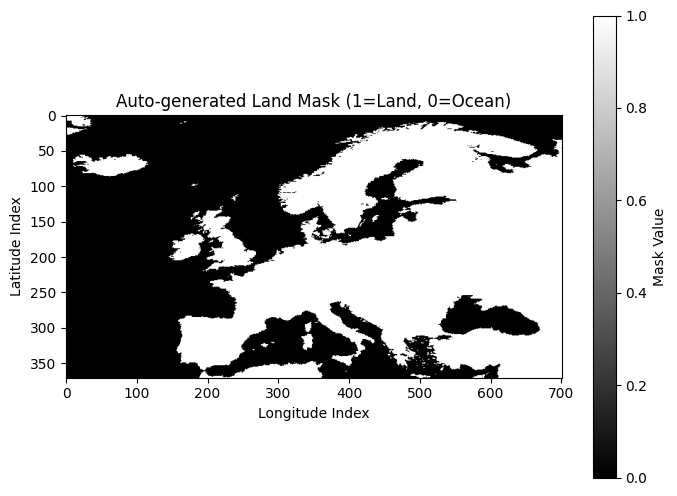

[2025-07-21 18:45:13.862] [INFO] Downsampled array shape: (121, 30, 30, 4)
[2025-07-21 18:45:13.863] [INFO] Downsampled Array (T, H, W, C) info:
[2025-07-21 18:45:13.863] [INFO]   shape: (121, 30, 30, 4)
[2025-07-21 18:45:13.863] [INFO]   dtype: float32
[2025-07-21 18:45:13.867] [INFO]   min: -0.0032, max: 0.7579
[2025-07-21 18:45:13.875] [INFO]   mean: 0.0389, std: 0.1123


In [5]:
# --- STEP 3: LOAD ALL MONTHLY FILES & CONCAT ---
def load_combined_data():
    monthly_arrays = []
    for month in config["months"]:
        arr = np.load(os.path.join(config["intermediate_folder"], f"{month}.npy"))
        monthly_arrays.append(arr)
    final_array = np.concatenate(monthly_arrays, axis=0)  # concat over day axis
    print(f"Final combined shape: {final_array.shape}")  # (days, lat, lon, channels)
    return final_array

data_array = load_combined_data()  # (T, H, W, C)

# Step 3: 自动生成land_mask（所有通道都为0的像元视为海洋）
# land_mask shape: (H, W)，1为陆地，0为海洋
land_mask = (np.any(data_array != 0, axis=(0, 3))).astype(np.float32)
print(f"Auto-generated land_mask shape: {land_mask.shape}, 陆地像元数: {np.sum(land_mask)}")

# 可视化掩膜
plt.figure(figsize=(8, 6))
plt.imshow(land_mask, cmap='gray')
plt.title('Auto-generated Land Mask (1=Land, 0=Ocean)')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.colorbar(label='Mask Value')
plt.show()

# Step 3: 降分辨率可视化
downsampled_array = array_info_displayer.downsample_channels(data_array, target_hw=30)
array_info_displayer.print_info(downsampled_array, name="Downsampled Array (T, H, W, C)")
aframe = downsampled_array[100,:,:,0]

In [6]:
# --- STEP 4: Transform to Tensor ---
def prepare_tensor_data(data):
    # (T, H, W, C) -> (T, C, H, W)
    return np.transpose(data, (0, 3, 1, 2))

tensor_data = prepare_tensor_data(data_array)
print(f"tensor data shape: {tensor_data.shape}")  # (T, C, H, W)


tensor data shape: (121, 4, 371, 701)


In [7]:
# tensor_data[50, 0, :, :]


In [7]:
# --- STEP 5: DATASET & DATALOADER Test ---

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50  # 单位是MB，设置为50MB

from src.datasets import SoilDataset

dataset = SoilDataset(tensor_data, config["input_days"], config["predict_days"])

total = len(dataset)
train_size = int(0.7 * total)
val_size = int(0.2 * total)
test_size = total - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(f"Dataset split: train={len(train_set)}, val={len(val_set)}, test={len(test_set)}")

train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True)

# ---------------- visualization ----------------
# x_sample, y_sample = dataset[0]
# print(f"Sample x shape: {x_sample.shape}, y shape: {y_sample.shape}")
# plot_tensor_sample(x_sample.numpy(), y_sample.numpy(), lat, lon)
from src.visualize import Visualizer
x_sample, y_sample = dataset[150]
# x_1, y_1 = dataset[50]
# x_2, y_2 = dataset[80]
# x_3, y_3 = dataset[110]
# x_4, y_4 = dataset[140]
# x1_c_1 = x_1[:, 0:1, :, :]
# x2_c_1 = x_2[:, 0:1, :, :]
# x3_c_1 = x_3[:, 0:1, :, :]
# x4_c_1 = x_4[:, 0:1, :, :]
# x_sample = torch.cat([x1_c_1, y_1, x2_c_1, y_2, x3_c_1, y_3, x4_c_1], dim=0)
# y_sample = y_4

print(f"Sample x shape: {x_sample.shape}, y shape: {y_sample.shape}")
visualizer = Visualizer(lat, lon)
x_to_map = np.transpose(x_sample[-1], (1, 2, 0))
print(f"x_to_map shape: {x_to_map.shape}")  # Should be (H, W, C)
visualizer.plot_variable_day(x_to_map, title="The first sample Day", channel_index=CHANNELS["swvl1"])
# visualizer.plot_tensor_sample(x_sample, y_sample)

from IPython.display import HTML

# Show animation inline for a specific channel (e.g., swvl1)

# Generate animations for different channels and display them separately

anim_swvl1 = visualizer.animate_tensor_sample(x_sample, y_sample, channel_index=CHANNELS["swvl1"])

anim_ro_in, anim_ro_out = visualizer.animate_tensor_sample(x_sample, y_sample, channel_index=CHANNELS["e"])

# Display each animation in its own output cell to avoid overlap
display(HTML(anim_swvl1.to_jshtml()))
display(HTML(anim_ro_in.to_jshtml()))
display(HTML(anim_ro_out.to_jshtml()))

Available samples: 92
Dataset split: train=64, val=18, test=10
Sample x shape: torch.Size([0, 4, 371, 701]), y shape: torch.Size([0, 1, 371, 701])


IndexError: index -1 is out of bounds for dimension 0 with size 0

In [8]:
x, y = dataset.__getitem__(0)  # Test if dataset works
print(x.shape, y.shape)

import importlib
import src.visualize
importlib.reload(src.visualize)
from src.visualize import Visualizer

# Select only the first channel from x to match y's channel dimension
x_first_channel = x[:, 0:1, :, :]  # shape: (input_days, 1, H, W)
print(f"x_first_channel shape: {x_first_channel.shape}")  # Should be (input_days, 1, H, W)
xy_combined = torch.cat([x_first_channel, y], dim=0)
print(xy_combined.shape)

torch.Size([20, 4, 371, 701]) torch.Size([10, 1, 371, 701])
x_first_channel shape: torch.Size([20, 1, 371, 701])
torch.Size([30, 1, 371, 701])


In [ ]:
# moved to models.py
# --- STEP 6: MODEL DEFINITION ---
# class ConvLSTMCell(nn.Module):
#     def __init__(self, input_dim, hidden_dim, kernel_size=3):
#         super().__init__()
#         padding = kernel_size // 2
#         self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)

#     def forward(self, x, h, c):
#         combined = torch.cat([x, h], dim=1)
#         gates = self.conv(combined)
#         i, f, o, g = torch.chunk(gates, 4, dim=1)
#         i = torch.sigmoid(i)
#         f = torch.sigmoid(f)
#         o = torch.sigmoid(o)
#         g = torch.tanh(g)
#         c_next = f * c + i * g
#         h_next = o * torch.tanh(c_next)
#         return h_next, c_next

# class ConvLSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim=16):  # hidden_dim可调小
#         super().__init__()
#         self.cell = ConvLSTMCell(input_dim, hidden_dim)
#         self.out = nn.Conv2d(hidden_dim, 1, 1)

#     def forward(self, x_seq):
#         b, t, c, h, w = x_seq.size()
#         h_t = torch.zeros((b, 16, h, w), device=x_seq.device)
#         c_t = torch.zeros((b, 16, h, w), device=x_seq.device)
#         for t_step in range(t):
#             h_t, c_t = self.cell(x_seq[:, t_step], h_t, c_t)
#         out = self.out(h_t)
#         return out.unsqueeze(1).repeat(1, config["predict_days"], 1, 1, 1)

In [9]:
# --- STEP 7-1: TRAINING LOOP part 1 ---
from src.models import ConvLSTM
from torch.utils.tensorboard import SummaryWriter
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTM(input_dim=len(config["use_channels"])).to(device)

# 1. 显示模型结构
print(model)

ConvLSTM(
  (cell): ConvLSTMCell(
    (conv): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (out): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [10]:
import datetime

# --- STEP 7-2: TRAINING LOOP part 2 ---

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')  # 用于mask后再mean

# TensorBoard writer
writer = SummaryWriter(log_dir="runs/soil_conv_lstm")

# Early stopping参数
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# 获取陆地掩膜（假设land_mask已在前面定义，shape: (lat, lon)）
# mask shape: (1, 1, H, W)，与y/pred最后两个维度一致
land_mask_tensor = torch.tensor(land_mask, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

# 
run_name = config["run_name"]

for epoch in range(config["epochs"]):
    model.train()
    epoch_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        # 3. 损失函数计算前应用掩膜
        mask = land_mask_tensor.expand_as(y)
        loss_map = criterion(pred, y) * mask
        loss = loss_map.sum() / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_train_loss, epoch)

    # 验证集loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in DataLoader(val_set, batch_size=config["batch_size"]):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model(x_val)
            mask_val = land_mask_tensor.expand_as(y_val)
            loss_map_val = criterion(pred_val, y_val) * mask_val
            loss_val = loss_map_val.sum() / mask_val.sum()
            val_loss += loss_val.item()
    avg_val_loss = val_loss / len(val_set)
    writer.add_scalar('Loss/val', avg_val_loss, epoch)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # 2. Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        timestamp = datetime.datetime.now().strftime("%Y%m%d")
        save_path = os.path.join("params", f"soil_conv_lstm_best_{timestamp}_{run_name}.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved to {save_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    # 定期保存检查点
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join("params", f"soil_conv_lstm_{timestamp}_{run_name}_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

writer.close()

[Epoch 1] Train Loss: 0.1999 | Val Loss: 0.0264
Best model saved to params/soil_conv_lstm_best_20250721_test-2.pth
[Epoch 2] Train Loss: 0.0243 | Val Loss: 0.0038
Best model saved to params/soil_conv_lstm_best_20250721_test-2.pth
[Epoch 3] Train Loss: 0.0083 | Val Loss: 0.0018
Best model saved to params/soil_conv_lstm_best_20250721_test-2.pth
[Epoch 4] Train Loss: 0.0066 | Val Loss: 0.0017
Best model saved to params/soil_conv_lstm_best_20250721_test-2.pth
[Epoch 5] Train Loss: 0.0058 | Val Loss: 0.0014
Best model saved to params/soil_conv_lstm_best_20250721_test-2.pth
Checkpoint saved to params/soil_conv_lstm_20250721_test-2_epoch5.pth
[Epoch 6] Train Loss: 0.0051 | Val Loss: 0.0013
Best model saved to params/soil_conv_lstm_best_20250721_test-2.pth
[Epoch 7] Train Loss: 0.0046 | Val Loss: 0.0012
Best model saved to params/soil_conv_lstm_best_20250721_test-2.pth
[Epoch 8] Train Loss: 0.0044 | Val Loss: 0.0011
Best model saved to params/soil_conv_lstm_best_20250721_test-2.pth
[Epoch 9] T

KeyboardInterrupt: 

In [26]:
# --- Save and Load Model ---
# 保存模型参数
def save_model(model, path="soil_conv_lstm.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# 加载模型参数
def load_model(model, path="soil_conv_lstm.pth", device='cpu'):
    model.load_state_dict(torch.load(path, map_location=device))
    print(f"Model loaded from {path}")
    return model

save_model(model,path="soil_conv_lstm-2.pth")
# model = load_model(model, device=device)

NameError: name 'model' is not defined

In [ ]:
# --- STEP 8: EVALUATION ---
def predict_and_visualize(model, dataset, lat, lon, device='cpu', sample_idx=0):
    model.eval()
    x, y_true = dataset[sample_idx]
    x = x.unsqueeze(0).to(device)  # (1, input_days, C, H, W)
    with torch.no_grad():
        y_pred = model(x)  # (1, pred_days, 1, H, W)
    y_pred = y_pred.squeeze(0).cpu().numpy()    # (pred_days, 1, H, W)
    y_true = y_true.numpy()                     # (pred_days, 1, H, W)

    # 可视化每一天的预测和真实
    for t in range(y_pred.shape[0]):
        plt.figure(figsize=(6, 6))
        plot_variable_day(np.transpose(y_true[t], (1,2,0)), lat, lon, 0, 0, f"True Day {t+1}")
        plt.show()
        plt.figure(figsize=(6, 6))
        plot_variable_day(np.transpose(y_pred[t], (1,2,0)), lat, lon, 0, 0, f"Predicted Day {t+1}")
        plt.show()
    return y_true, y_pred

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_metrics(y_true, y_pred):
    # 输入: (pred_days, 1, H, W)
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")
    return {"RMSE": rmse, "MSE": mse, "MAE": mae, "R2": r2}


# 加载模型（推理时建议重新加载，防止训练态）
model_eval = load_model(model, "soil_conv_lstm-2.pth", device=device)
model_eval.eval()

# 选一个测试样本预测并可视化
sample_idx = 0  # 你可以换成其它test_set中的样本
y_true, y_pred = predict_and_visualize(model_eval, test_set, lat, lon, device=device, sample_idx=sample_idx)

# 计算指标
metrics = compute_metrics(y_true, y_pred)


平均指标（1~predict_days）:
RMSE均值: 0.0446, MAE均值: 0.0239, R2均值: 0.9146


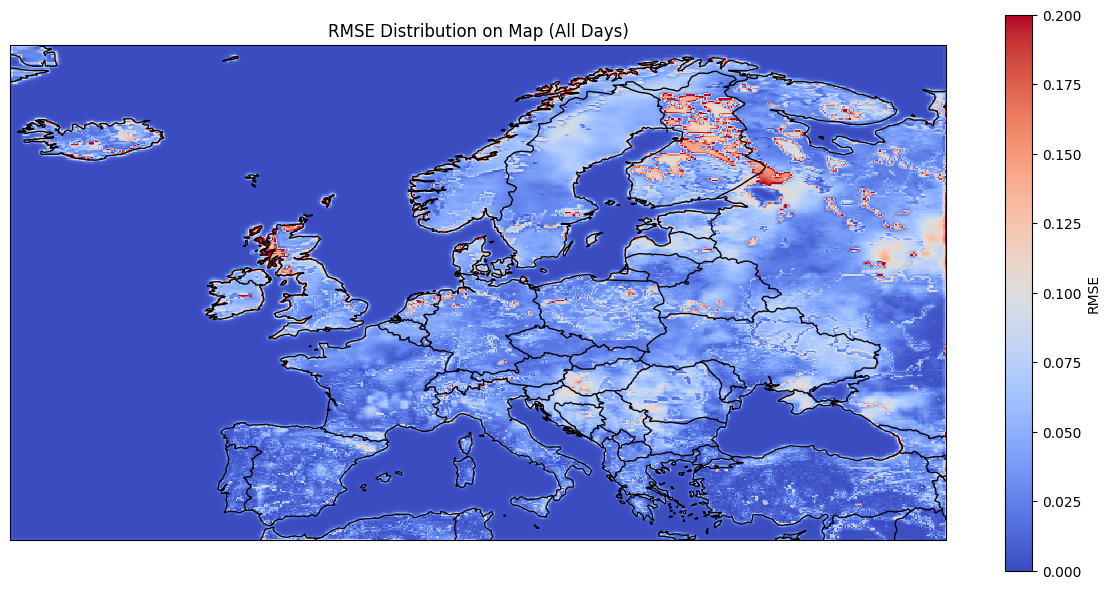

/tmp/ipykernel_2007/1684855790.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_rmse[~np.isnan(all_rmse)], all_mae[~np.isnan(all_mae)]], labels=['RMSE', 'MAE'], showfliers=False)


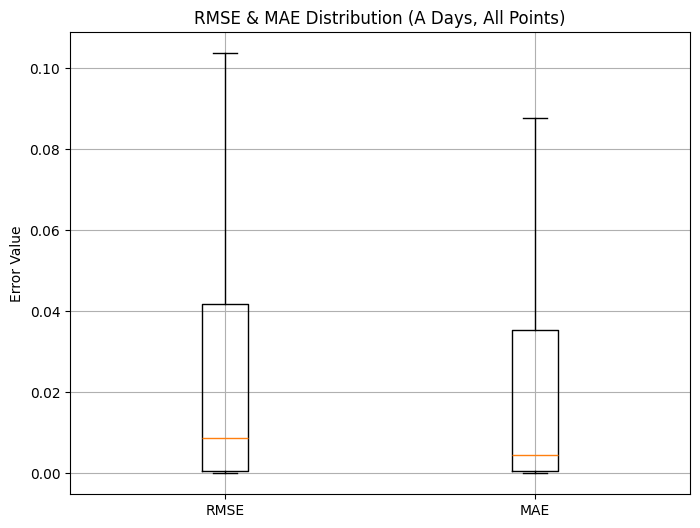

累积分布表:
             RMSE          MAE               R2
count 260071.0000 2600710.0000     2600710.0000
mean       0.0260       0.0239       -2698.8000
std        0.0364       0.0378     1264275.6250
min        0.0000       0.0000 -1392201344.0000
25%        0.0005       0.0005           0.9046
50%        0.0086       0.0046           0.9978
75%        0.0418       0.0354           1.0000
max        0.6236       0.6580           1.0000


/tmp/ipykernel_2007/1684855790.py:81: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc = desc.applymap(lambda x: round(x, 4))


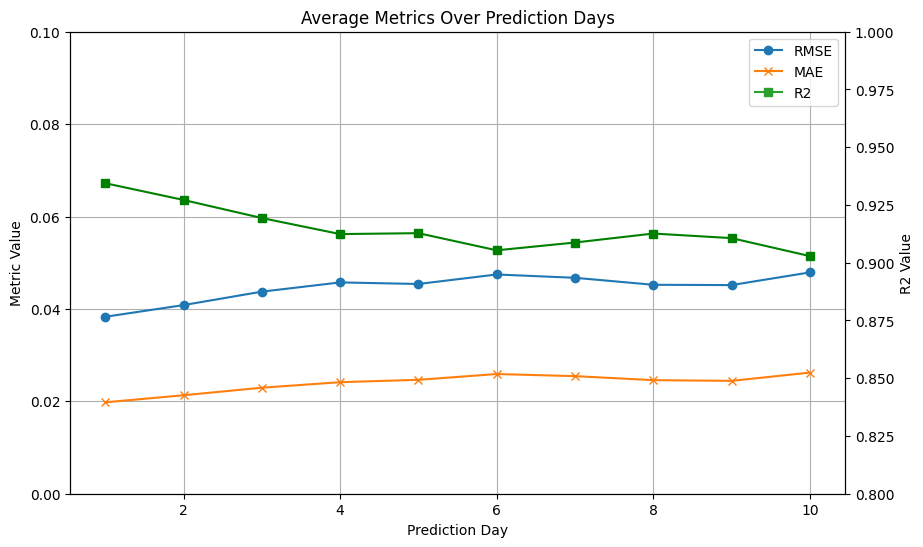

In [43]:
# 1. 生成从第1到第predict_days天的metrics总平均指标结果
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

predict_days = y_pred.shape[0]
lat_dim, lon_dim = y_pred.shape[1], y_pred.shape[2]

rmse_list, mae_list, r2_list = [], [], []
rmse_map_list, mae_map_list, r2_map_list = [], [], []

sq_err_stack = []
for t in range(predict_days):
    y_true_flat = y_true[t].flatten()
    y_pred_flat = y_pred[t].flatten()
    mask = np.isfinite(y_true_flat) & np.isfinite(y_pred_flat)
    rmse = np.sqrt(mean_squared_error(y_true_flat[mask], y_pred_flat[mask]))
    mae = mean_absolute_error(y_true_flat[mask], y_pred_flat[mask])
    r2 = r2_score(y_true_flat[mask], y_pred_flat[mask])
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    # Per-pixel metrics
    # rmse_map = np.sqrt((y_true[t] - y_pred[t])**2)
    # rmse_map = np.squeeze(rmse_map)  # shape: (371, 701)
    sq_err = (y_true[t] - y_pred[t])**2  # shape: (1, H, W)
    sq_err_stack.append(np.squeeze(sq_err))  # shape: (H, W)
    mae_map = np.abs(y_true[t] - y_pred[t])
    # r2_map: 逐点R2
    with np.errstate(divide='ignore', invalid='ignore'):
        ss_res = (y_true[t] - y_pred[t])**2
        ss_tot = (y_true[t] - np.nanmean(y_true[t]))**2
        r2_map = 1 - np.divide(ss_res, ss_tot, out=np.full_like(ss_res, np.nan), where=ss_tot!=0)
    # rmse_map_list.append(rmse_map)
    mae_map_list.append(mae_map)
    r2_map_list.append(r2_map)

sq_err_stack = np.stack(sq_err_stack, axis=0)  # shape: (T, H, W)
rmse_map = np.sqrt(np.nanmean(sq_err_stack, axis=0))  # shape: (H, W)
rmse_map_list = [rmse_map]  # 之后的统计和可视化都用 rmse_map_list[0]

print("平均指标（1~predict_days）:")
print("RMSE均值: {:.4f}, MAE均值: {:.4f}, R2均值: {:.4f}".format(
    np.mean(rmse_list), np.mean(mae_list), np.mean(r2_list)
))

# 2. 可视化前10天平均RMSE Distribution on Map
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
rmse_map_to_plot = np.nanmean(np.stack(rmse_map_list[:10]), axis=0)  # 保证是 (lat, lon)
im = ax.pcolormesh(lon, lat, rmse_map_to_plot, cmap='coolwarm', shading='auto',  vmin=0, vmax=0.2)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("RMSE Distribution on Map (All Days)")
plt.colorbar(im, orientation='vertical', label='RMSE')
plt.tight_layout()
plt.show()

# 3. RMSE 和 MAE 的总分布箱型图
import seaborn as sns
all_rmse = np.stack(rmse_map_list).flatten()
all_mae = np.stack(mae_map_list).flatten()
plt.figure(figsize=(8, 6))
plt.boxplot([all_rmse[~np.isnan(all_rmse)], all_mae[~np.isnan(all_mae)]], labels=['RMSE', 'MAE'], showfliers=False)
plt.title("RMSE & MAE Distribution (A Days, All Points)")
plt.ylabel("Error Value")
plt.grid(True) 
plt.show()

# 4. 统计RMSE，MAE，R2的累积分布表
metrics_dict = {
    'RMSE': all_rmse[~np.isnan(all_rmse)],
    'MAE': all_mae[~np.isnan(all_mae)],
    'R2': np.stack(r2_map_list).flatten()[~np.isnan(np.stack(r2_map_list).flatten())]
}
summary_df = pd.DataFrame({k: pd.Series(v) for k, v in metrics_dict.items()})
desc = summary_df.describe(percentiles=[.25, .5, .75])
desc = desc.applymap(lambda x: round(x, 4))
print("累积分布表:")
with pd.option_context('display.float_format', '{:.4f}'.format):
    print(desc)

# 5. 绘制总平均rmse，mae，和r2随预测天数预测的折线图
plt.figure(figsize=(10, 6))
plt.plot(range(1, predict_days+1), rmse_list, marker='o', label='RMSE')
plt.plot(range(1, predict_days+1), mae_list, marker='x', label='MAE')
plt.plot(range(1, predict_days+1), r2_list, marker='s', label='R2')
plt.xlabel("Prediction Day")
plt.ylabel("Metric Value")
plt.title("Average Metrics Over Prediction Days")
plt.legend()
plt.grid(True)
plt.ylim(0, 0.1)  # RMSE和MAE
plt.twinx()
plt.plot(range(1, predict_days+1), r2_list, marker='s', color='g', label='R2')
plt.ylim(0.8, 1)  # R2
plt.ylabel("R2 Value")
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(1, 201), all_mae[1000:1200], label='MAE')
# plt.plot(np.arange(1, all_rmse.shape[0] + 1), all_rmse, label='RMSE')

plt.xlabel("Index (1 ~ {})".format(all_rmse.shape[0]))
plt.ylabel("Error Value")
plt.title("All RMSE and MAE (Flattened) Line Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# np.mean(all_rmse)

# # count number of all_rmse > mean
# count_above_mean = np.sum(all_rmse > 0.1)
# print(f"Number of RMSE values above mean: {count_above_mean}")

all_rmse - all_mae

array([0., 0., 0., ..., 0., 0., 0.], shape=(2600710,), dtype=float32)